In [183]:
import warnings
warnings.filterwarnings("ignore")

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import LearningRateScheduler
import math
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader

In [186]:
def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over time")
    plt.legend()
    plt.show()

In [187]:
def standardise_data(data, dtype='train', scaler=None):
    if dtype == 'train':
        # Create a scaler object
        scaler = StandardScaler()
        # Fit and transform the data
        data = np.array(data)
        data_norm = scaler.fit_transform(data)
    elif dtype == 'test':
        # Only transform the data
        data_norm = scaler.transform(data)
    
    return data_norm, scaler

In [188]:
def minmax_data(data, dtype='train', scaler=None):

    if dtype == 'train':
        # Create a scaler object
        scaler = MinMaxScaler()
        # Fit and transform the data
        data = np.array(data)
        data_norm = scaler.fit_transform(data)
    elif dtype == 'test':
        data_norm = scaler.transform(data)
    
    return data_norm, scaler

In [189]:
def split_dataset(X, Y, test_size=0.2,random_state=42):
    # Split into train and test sets
    X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    return X_train, X_val, y_train, y_val

In [190]:
def rebuild_data(df, var, ts=30):
    input_values = []
    target_values = []

    for location in df['loc'].unique():
        loc_df = df[df['loc'] == location]  # select the current location only
        loc_df['date'] = pd.to_datetime(loc_df['date'])
        loc_df = loc_df.sort_values('date')  # sort the data
        loc_df.reset_index(drop=True, inplace=True)  # reset the index

        # find the time gap
        time_gaps = loc_df['date'].diff() > pd.Timedelta(1, 'D')
        time_gaps = time_gaps[time_gaps].index.tolist()

        start = 0
        if time_gaps != []:
            for end in time_gaps:
                # Subtract ts from end so that i+ts will not go out of bounds
                for i in range(start, end - ts):
                    input_values.append(loc_df[var][i:i+ts])
                    target_values.append(loc_df['station_SWE'][i+ts])
                start = end + 1

        # last continuous time series
        if len(loc_df) - start >= ts:  # Add this line
            for i in range(start, len(loc_df) - ts):
                input_values.append(loc_df[var][i:i+ts])
                target_values.append(loc_df['station_SWE'][i+ts])

    input_values = np.array(input_values)
    target_values = np.array(target_values)
    
    return input_values, target_values


In [191]:
def check_time_continuity(df):
    for location in df['loc'].unique():
        loc_df = df[df['loc'] == location]  # select the current location only
        loc_df['date'] = pd.to_datetime(loc_df['date']) 
        loc_df = loc_df.sort_values('date')

        # calculate difference between two dates
        loc_df['time_diff'] = loc_df['date'].diff().dt.days

        # if the difference > 1 then print it out
        if any(loc_df['time_diff'] > 1):
            print(f"Location {location} has discontinuous time data at the following dates:")
            print(loc_df[loc_df['time_diff'] > 1]['date'])
            return False

    print("All locations have continuous time data.")
    return True

In [192]:
folder_path = '/Users/yz6622/Desktop/IRP/dataset/swiss_station/Preprocessed_data/'

In [193]:
file_path = folder_path + 'train.csv'

# read data
df = pd.read_csv(file_path)

         date        HS  station_SWE  Sturm_SWE (cm)  deltaSnow_SWE (cm)  \
0  2003-09-30  0.000000     0.000000        0.000000            0.000000   
1  2003-10-01  0.005578     0.368191        0.002497            0.002397   
2  2003-10-02  0.005129     0.351574        0.002309            0.002397   
3  2003-10-03  0.004589     0.395334        0.002077            0.002397   
4  2003-10-04  0.005668     0.395153        0.002585            0.002397   

            loc  precipitation      snowfall  solar_radiation  temperature  \
0  canada_3A25P   3.662044e-08  3.663723e-08         0.032299     0.522216   
1  canada_3A25P   3.662044e-08  3.663723e-08         0.030108     0.555290   
2  canada_3A25P   5.450587e-04  3.663723e-08         0.029086     0.508123   
3  canada_3A25P   1.820036e-05  3.663723e-08         0.028209     0.517716   
4  canada_3A25P   5.452784e-05  3.663723e-08         0.027096     0.476645   

       rain     month  
0  0.062383  0.727273  
1  0.062383  0.818182  
2 

In [194]:
# set the datetime and sort the values
df = df.sort_values(by="date")
df.reset_index(drop=True, inplace=True)

In [195]:
file_path = folder_path + 'test.csv'

# read data
df_test = pd.read_csv(file_path)

         date        HS  station_SWE  Sturm_SWE (cm)  deltaSnow_SWE (cm)  \
0  2008-10-02  0.010750     2.788030        0.004870            0.012337   
1  2008-10-03  0.009824     2.538696        0.004473            0.011273   
2  2008-10-04  0.008898     2.111562        0.004072            0.010210   
3  2008-10-05  0.007971     1.740292        0.003666            0.009147   
4  2008-10-06  0.007045     1.235040        0.003257            0.008084   

            loc  precipitation      snowfall  solar_radiation  temperature  \
0  canada_4B16P   3.662044e-08  3.663723e-08         0.017846     0.512300   
1  canada_4B16P   2.580432e-01  3.663723e-08         0.004604     0.488581   
2  canada_4B16P   1.571692e-01  3.663723e-08         0.005102     0.490934   
3  canada_4B16P   2.680880e-01  2.984925e-02         0.006188     0.418342   
4  canada_4B16P   1.960084e-02  6.193011e-03         0.014789     0.422286   

       rain     month  
0  0.062383  0.818182  
1  0.314164  0.818182  
2 

In [196]:
# df_test['month_ori'] = df_test['month'] * (12 - 1) + 1
# df['month_ori'] = df['month'] * (12 - 1) + 1

In [197]:
# df_test['month_sin'] = np.sin(2 * np.pi * df_test['month_ori']/12.0)
# df_test['month_cos'] = np.cos(2 * np.pi * df_test['month_ori']/12.0)
# df['month_sin'] = np.sin(2 * np.pi * df['month_ori']/12.0)
# df['month_cos'] = np.cos(2 * np.pi * df['month_ori']/12.0)

In [198]:
def get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, feature_idx, batch_size=32, ts=90):
    # Convert data to torch tensors
    X_train = torch.tensor(X_train_90[:,:,0:feature_idx+1].reshape(-1,ts,feature_idx+1)).float()
    X_val = torch.tensor(X_val_90[:,:,0:feature_idx+1].reshape(-1,ts,feature_idx+1)).float()
    X_test = torch.tensor(X_test_90[:,:,0:feature_idx+1].reshape(-1,ts,feature_idx+1)).float()
    y_train = torch.tensor(y_train_90.reshape(-1,1)).float()
    y_val = torch.tensor(y_val_90.reshape(-1,1)).float()
    y_test = torch.tensor(y_test_90.reshape(-1,1)).float()

    # Create data loaders
    train_data = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    val_data = TensorDataset(X_val, y_val)
    val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)
    test_data = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

    return train_loader, val_loader, test_loader


In [1]:
def evaluate_model(test_loader, model, y_scaler):
    # evaluation mode
    model.eval()

    test_predictions = []
    y_test_real = []

    # predict on the test data
    with torch.no_grad():
        for i, (X, Y) in enumerate(test_loader):
            X = X.float()
            Y = Y.float()
            outputs = model(X)
            test_predictions.append(outputs.numpy())
            y_test_real.append(Y.numpy())

    # concatenate the list of numpy arrays into one numpy array
    test_predictions = np.concatenate(test_predictions).reshape(-1, 1)
    y_test_real = np.concatenate(y_test_real).reshape(-1, 1)

    # reverse the scaling
    test_pred = y_scaler.inverse_transform(test_predictions)
    y_test_ori = y_scaler.inverse_transform(y_test_real)
    
    # Calculate the mean squared error
    mse_test = mean_squared_error(y_test_ori, test_pred)
    kge_test = kge(y_test_ori.reshape(-1), test_pred.reshape(-1))

    print('Mean Squared Error on Test Data:', mse_test)
    print('Kling-Gupta efficiency on Test Data:', kge_test)
    
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test_ori, test_pred, alpha=0.5)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('Scatter Plot of True vs Predicted Values')
    plt.plot([min(y_test_ori), max(y_test_ori)], [min(y_test_ori), max(y_test_ori)], color='red')  # plot y_true=y_pred
    plt.show()

In [200]:
evaluate_model(test_loader, model_1, scaler_y)class LSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, num_epochs=50, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True) 
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.num_epochs = num_epochs

    def forward(self, x):
        lstm_out, _ = self.lstm(x) 
        out = self.fc(lstm_out[:, -1, :])
        return out

    def train_model(self, ts, n_features, train_loader, val_loader, optimizer, criterion, scheduler):
        train_losses = []
        val_losses = []
        for epoch in range(self.num_epochs):
            # Training
            self.train()  # Set the model to training mode
            running_train_loss = 0.0
            for i, (X, Y) in enumerate(train_loader):
                X = X.float()
                Y = Y.float()
                optimizer.zero_grad()
                outputs = self(X.reshape(-1, ts, n_features)) 
                loss = criterion(outputs, Y)
                loss.backward()
                optimizer.step()
                running_train_loss += loss.item() * X.size(0)
            avg_train_loss = running_train_loss / len(train_loader.dataset)
            train_losses.append(avg_train_loss)

            # Validation
            self.eval()  # Set the model to evaluation mode
            running_val_loss = 0.0
            with torch.no_grad():
                for i, (X, Y) in enumerate(val_loader):
                    X = X.float()
                    Y = Y.float()
                    outputs = self(X.reshape(-1, ts, n_features))
                    loss = criterion(outputs, Y)
                    running_val_loss += loss.item() * X.size(0)
            avg_val_loss = running_val_loss / len(val_loader.dataset)
            val_losses.append(avg_val_loss)

            print(f'Epoch {epoch+1}/{self.num_epochs}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}')

            # Decay Learning Rate
            scheduler.step()

        return train_losses, val_losses

# HS

In [ ]:
input_values, target_values = rebuild_data(df, ['HS'], 90)

In [ ]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS'], 90)

In [ ]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [ ]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [ ]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 0, batch_size=32)

In [ ]:
model_1 = LSTM(input_dim=1, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [77]:
train_losses, val_losses = model_1.train_model(90,1,train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.005132231748175554, Val Loss: 0.002971686893109138
Epoch 2/100, Train Loss: 0.0029081885357964024, Val Loss: 0.002824208339414011
Epoch 3/100, Train Loss: 0.0029122740346990915, Val Loss: 0.0026528648938605433
Epoch 4/100, Train Loss: 0.0027643492773512827, Val Loss: 0.0027111450000918244
Epoch 5/100, Train Loss: 0.002730734485519422, Val Loss: 0.002678015897645605
Epoch 6/100, Train Loss: 0.0027457703492369066, Val Loss: 0.002789588999179686
Epoch 7/100, Train Loss: 0.0026922799555955217, Val Loss: 0.002751422086512058
Epoch 8/100, Train Loss: 0.002687736703270103, Val Loss: 0.003071670985103178
Epoch 9/100, Train Loss: 0.0027165326489659736, Val Loss: 0.0026072215535577104
Epoch 10/100, Train Loss: 0.0026706525500816503, Val Loss: 0.002613778324631322
Epoch 11/100, Train Loss: 0.0025396437743712844, Val Loss: 0.0025879903692274694
Epoch 12/100, Train Loss: 0.002557344927632464, Val Loss: 0.0025898669371448644
Epoch 13/100, Train Loss: 0.0025061518104802106,

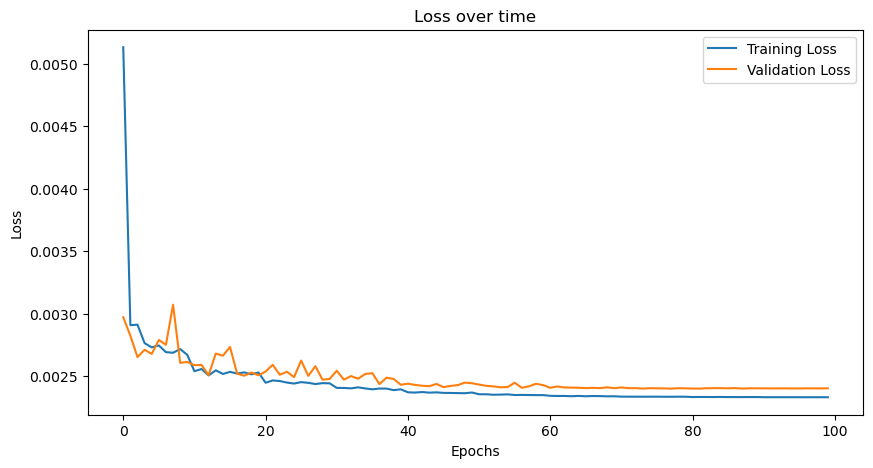

In [78]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [79]:
evaluate_model(test_loader, model_1, scaler_y)

Mean Squared Error on Test Data: 50.72571


# HS + snowfall

In [127]:
input_values, target_values = rebuild_data(df, ['HS','snowfall','temperature','solar_radiation','rain','month_sin','precipitation'], 90)

In [128]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS','snowfall','temperature','solar_radiation','rain','month_sin','precipitation'], 90)

In [129]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [130]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [131]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [136]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 1, batch_size=32)

In [138]:
model_1 = LSTM(input_dim=2, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [57]:
train_losses, val_losses = model_1.train_model(90, 2, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.0054628647385724675, Val Loss: 0.002666067798321038
Epoch 2/100, Train Loss: 0.002914735716682227, Val Loss: 0.0026656614790085556
Epoch 3/100, Train Loss: 0.002876248156772703, Val Loss: 0.0028301447290348877
Epoch 4/100, Train Loss: 0.0028255100788913763, Val Loss: 0.0042385012962072015
Epoch 5/100, Train Loss: 0.0028355390753213457, Val Loss: 0.003126274366083047
Epoch 6/100, Train Loss: 0.0027344673895703994, Val Loss: 0.003014115030820135
Epoch 7/100, Train Loss: 0.0027205622077450596, Val Loss: 0.002610250331195818
Epoch 8/100, Train Loss: 0.0026965870562798313, Val Loss: 0.0027005515445447407
Epoch 9/100, Train Loss: 0.0027183032242715233, Val Loss: 0.002858515881592011
Epoch 10/100, Train Loss: 0.002693663199828893, Val Loss: 0.002725813427619764
Epoch 11/100, Train Loss: 0.0025238223663663914, Val Loss: 0.0025573785947165064
Epoch 12/100, Train Loss: 0.0025138104292833376, Val Loss: 0.0025880543646631285
Epoch 13/100, Train Loss: 0.002505462459040272

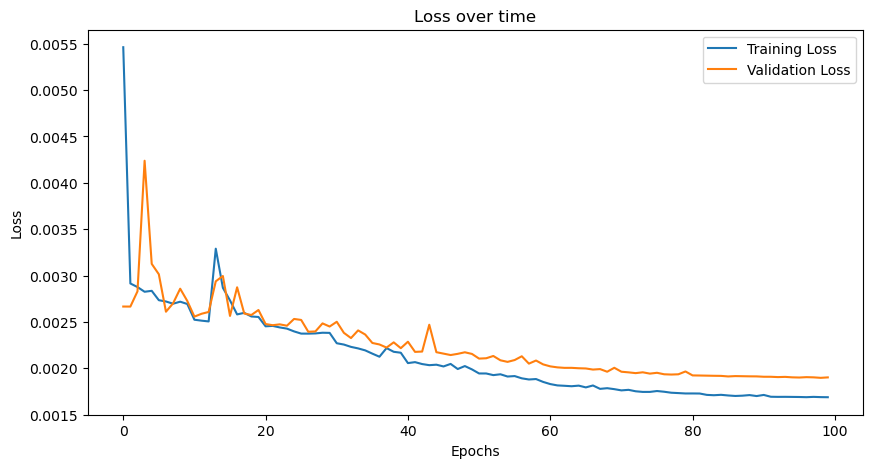

In [58]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [61]:
evaluate_model(test_loader, model_1, scaler_y)

Mean Squared Error on Test Data: 81.07003


# HS + solar

In [239]:
input_values, target_values = rebuild_data(df, ['HS','solar_radiation','rain','temperature','snowfall','month_sin','precipitation'], 90)

In [240]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS','solar_radiation','rain','temperature','snowfall','month_sin','precipitation'], 90)

In [241]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [242]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [243]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [244]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 1, batch_size=32)

In [245]:
model_2 = LSTM(input_dim=1, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [246]:
train_losses, val_losses = model_2.train_model(90, 1, train_loader, val_loader, optimizer, criterion, scheduler)

In [247]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [248]:
evaluate_model(test_loader, model_2, scaler_y)

# HS + rain

In [72]:
input_values, target_values = rebuild_data(df, ['HS','rain'], 90)

In [73]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS','rain'], 90)

In [74]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [75]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [76]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [77]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 1, batch_size=32)

In [78]:
model_3 = LSTM(input_dim=2, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [79]:
train_losses, val_losses = model_3.train_model(90, 2, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.004699774578940097, Val Loss: 0.002943668459434506
Epoch 2/100, Train Loss: 0.002918121985400198, Val Loss: 0.0027636109457505925
Epoch 3/100, Train Loss: 0.0027998525265746123, Val Loss: 0.0029039888962975532
Epoch 4/100, Train Loss: 0.0027282674898287053, Val Loss: 0.0026470520001977333
Epoch 5/100, Train Loss: 0.002731829145016892, Val Loss: 0.003003826893997187
Epoch 6/100, Train Loss: 0.002691090524965721, Val Loss: 0.0028809570410668795
Epoch 7/100, Train Loss: 0.0026803789543361, Val Loss: 0.002781759299899347
Epoch 8/100, Train Loss: 0.0026158765183790615, Val Loss: 0.0028577421691826804
Epoch 9/100, Train Loss: 0.0026514167398245868, Val Loss: 0.002871970193030225
Epoch 10/100, Train Loss: 0.00263576735816607, Val Loss: 0.0025852937552874526
Epoch 11/100, Train Loss: 0.0025387485308851127, Val Loss: 0.0028898199694063044
Epoch 12/100, Train Loss: 0.002517102056961869, Val Loss: 0.0025768810211780012
Epoch 13/100, Train Loss: 0.0024870445534103513, Va

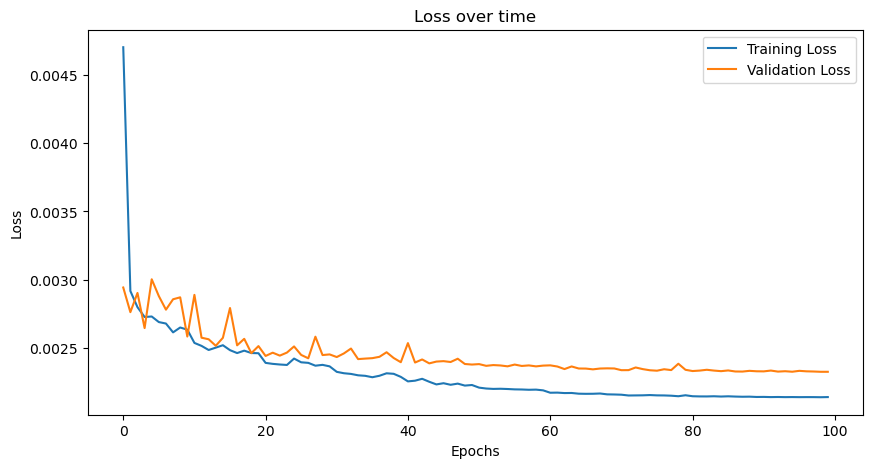

In [80]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [81]:
evaluate_model(test_loader, model_3, scaler_y)

Mean Squared Error on Test Data: 50.138298


# HS + precipitation

In [82]:
input_values, target_values = rebuild_data(df, ['HS','precipitation'], 90)

In [83]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS','precipitation'], 90)

In [84]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [85]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [86]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [87]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 1, batch_size=32)

In [88]:
model_4 = LSTM(input_dim=2, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [89]:
train_losses, val_losses = model_4.train_model(90, 2, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.0044810657169044605, Val Loss: 0.0032435499429232053
Epoch 2/100, Train Loss: 0.0028087504360527955, Val Loss: 0.002778163123018502
Epoch 3/100, Train Loss: 0.0028253696369905713, Val Loss: 0.0026839984961640802
Epoch 4/100, Train Loss: 0.002820081067513228, Val Loss: 0.0036158226405199794
Epoch 5/100, Train Loss: 0.0027316811355553327, Val Loss: 0.0027051270287567985
Epoch 6/100, Train Loss: 0.0027373340731941176, Val Loss: 0.002660282671918911
Epoch 7/100, Train Loss: 0.0026782420887092946, Val Loss: 0.0030746125033636333
Epoch 8/100, Train Loss: 0.0026220971616891403, Val Loss: 0.0029249641288236618
Epoch 9/100, Train Loss: 0.002662160139457337, Val Loss: 0.0028049809927968073
Epoch 10/100, Train Loss: 0.0025851368361280123, Val Loss: 0.0026245578604040917
Epoch 11/100, Train Loss: 0.002484636463458704, Val Loss: 0.0026926368980127176
Epoch 12/100, Train Loss: 0.0025011905612967833, Val Loss: 0.002482973773155146
Epoch 13/100, Train Loss: 0.002488190066443

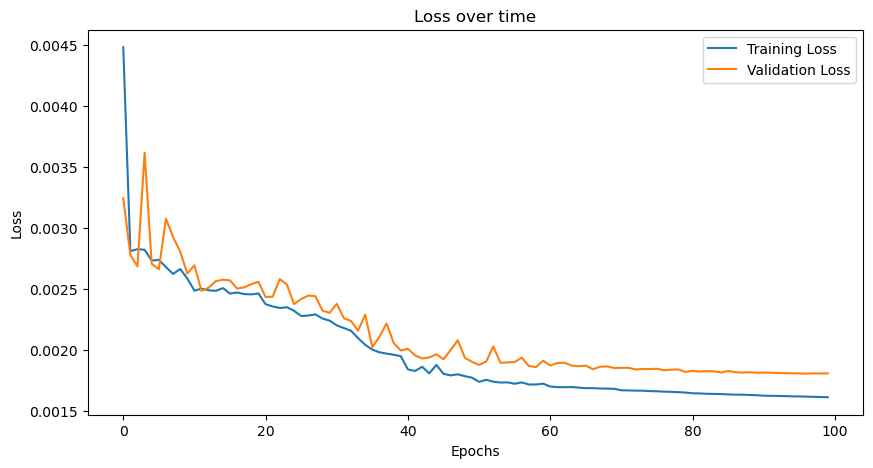

In [90]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [91]:
evaluate_model(test_loader, model_4, scaler_y)

Mean Squared Error on Test Data: 59.01044


# HS + temperature + rain + precipitation + solar

In [152]:
input_values, target_values = rebuild_data(df, ['HS','temperature','rain','precipitation','solar_radiation'], 90)

In [153]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS','temperature','rain','precipitation','solar_radiation'], 90)

In [154]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [155]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [156]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [157]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 4, batch_size=32)

In [158]:
model_uppp = LSTM(input_dim=5, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_uppp.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [159]:
train_losses, val_losses = model_uppp.train_model(90, 5, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.004850356194534837, Val Loss: 0.0026721032113610137
Epoch 2/100, Train Loss: 0.002857539174396529, Val Loss: 0.0027394379822819727
Epoch 3/100, Train Loss: 0.0027621702355961875, Val Loss: 0.002667940480194125
Epoch 4/100, Train Loss: 0.0026775922047825498, Val Loss: 0.0029282904272505657
Epoch 5/100, Train Loss: 0.002714298237817906, Val Loss: 0.0026305294572543823
Epoch 6/100, Train Loss: 0.0026209674579090055, Val Loss: 0.0027196499410199696
Epoch 7/100, Train Loss: 0.002723448758561306, Val Loss: 0.002602316319164131
Epoch 8/100, Train Loss: 0.002537244919152886, Val Loss: 0.0025338072858041402
Epoch 9/100, Train Loss: 0.00264333396691603, Val Loss: 0.0024236819422333114
Epoch 10/100, Train Loss: 0.0025412603656069094, Val Loss: 0.002572092068985118
Epoch 11/100, Train Loss: 0.002423235490492562, Val Loss: 0.0023794425789070137
Epoch 12/100, Train Loss: 0.002385477960262085, Val Loss: 0.0024502951217250436
Epoch 13/100, Train Loss: 0.0023269094435014724, 

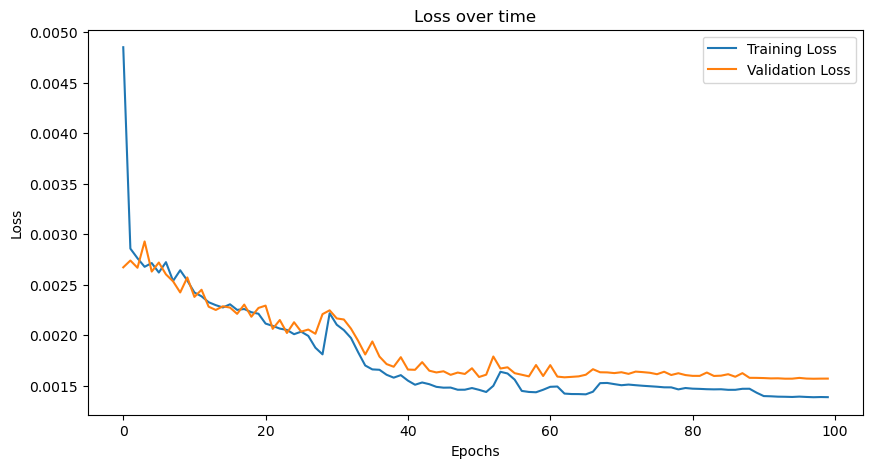

In [160]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [161]:
evaluate_model(test_loader, model_uppp, scaler_y)

Mean Squared Error on Test Data: 62.52301


# HS + temperature + rain + solar

In [162]:
input_values, target_values = rebuild_data(df, ['HS','temperature','rain','solar_radiation'], 90)

In [163]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS','temperature','rain','solar_radiation'], 90)

In [164]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [165]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [166]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [168]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 3, batch_size=32)

In [169]:
model_upppp = LSTM(input_dim=4, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_uppp.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [170]:
train_losses, val_losses = model_upppp.train_model(90, 4, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.028481558883518023, Val Loss: 0.02683740959835612
Epoch 2/100, Train Loss: 0.028481558981510495, Val Loss: 0.02683740959835612
Epoch 3/100, Train Loss: 0.028481558960335714, Val Loss: 0.02683740959835612
Epoch 4/100, Train Loss: 0.028481558864812757, Val Loss: 0.02683740959835612
Epoch 5/100, Train Loss: 0.028481559010671797, Val Loss: 0.02683740959835612
Epoch 6/100, Train Loss: 0.028481558850626178, Val Loss: 0.02683740959835612
Epoch 7/100, Train Loss: 0.028481558850205837, Val Loss: 0.02683740959835612
Epoch 8/100, Train Loss: 0.028481558940474508, Val Loss: 0.02683740959835612
Epoch 9/100, Train Loss: 0.028481559029482146, Val Loss: 0.02683740959835612
Epoch 10/100, Train Loss: 0.02848155889875546, Val Loss: 0.02683740959835612
Epoch 11/100, Train Loss: 0.02848155900688871, Val Loss: 0.02683740959835612
Epoch 12/100, Train Loss: 0.028481558990285157, Val Loss: 0.02683740959835612
Epoch 13/100, Train Loss: 0.02848155891430815, Val Loss: 0.0268374095983561

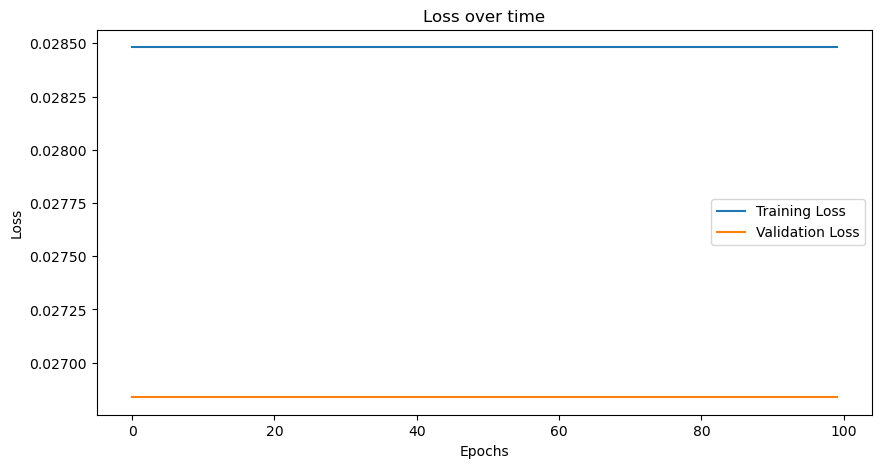

In [171]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [172]:
evaluate_model(test_loader, model_upppp, scaler_y)

Mean Squared Error on Test Data: 2186.4854


# HS + temperature + rain + precipitation

In [106]:
input_values, target_values = rebuild_data(df, ['HS','temperature','rain','precipitation'], 90)

In [107]:
X_test_90, y_test_90 = rebuild_data(df_test, ['HS','temperature','rain','precipitation'], 90)

In [108]:
X_train_90, X_val_90, y_train_90, y_val_90 = split_dataset(input_values, target_values)

In [109]:
y_train_90, scaler_y = minmax_data(np.array(y_train_90).reshape(-1,1), 'train')

In [110]:
y_val_90, _ = minmax_data(np.array(y_val_90).reshape(-1,1), 'test', scaler_y)
y_test_90, _ = minmax_data(np.array(y_test_90).reshape(-1,1), 'test', scaler_y)

In [121]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_90, y_train_90, X_val_90, y_val_90, X_test_90, y_test_90, 3, batch_size=32)

In [122]:
model_upp = LSTM(input_dim=4, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_upp.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [123]:
train_losses, val_losses = model_upp.train_model(90, 4, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.004398251954986279, Val Loss: 0.003030929425924626
Epoch 2/100, Train Loss: 0.0028204106957729173, Val Loss: 0.002663634486209823
Epoch 3/100, Train Loss: 0.0027792612636167616, Val Loss: 0.002870063073025337
Epoch 4/100, Train Loss: 0.002839151535981843, Val Loss: 0.002687776137634251
Epoch 5/100, Train Loss: 0.002725160462421868, Val Loss: 0.002662900955998759
Epoch 6/100, Train Loss: 0.0027169099002774433, Val Loss: 0.0025864608974796163
Epoch 7/100, Train Loss: 0.0026793858828614184, Val Loss: 0.0025803582745542015
Epoch 8/100, Train Loss: 0.0026351985581644795, Val Loss: 0.0028468738444526057
Epoch 9/100, Train Loss: 0.0026379107308806523, Val Loss: 0.0025529162201774896
Epoch 10/100, Train Loss: 0.002645247464024886, Val Loss: 0.002846939013917873
Epoch 11/100, Train Loss: 0.0024595362226490576, Val Loss: 0.002454765065361339
Epoch 12/100, Train Loss: 0.002440794686260088, Val Loss: 0.0024880292321704934
Epoch 13/100, Train Loss: 0.0024359656733228224, 

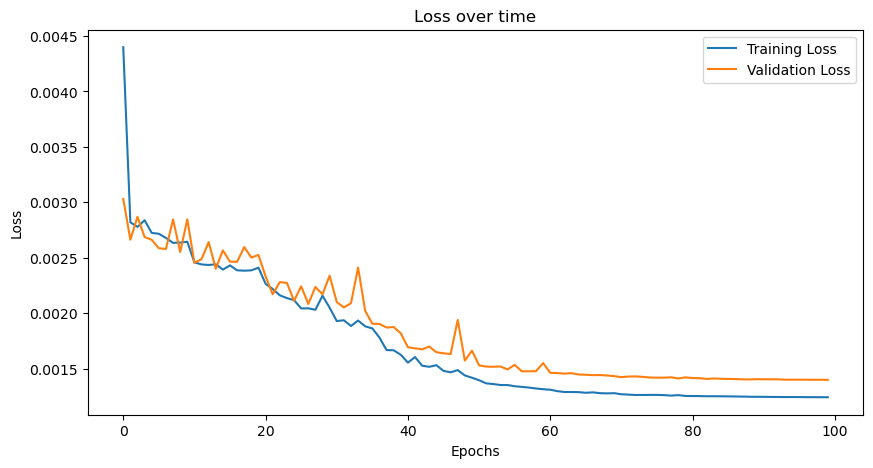

In [124]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [125]:
evaluate_model(test_loader, model_upp, scaler_y)

Mean Squared Error on Test Data: 68.36548


# HS + temperature + rain

In [116]:
model_up = LSTM(input_dim=3, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_up.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [117]:
train_losses, val_losses = model_up.train_model(90, 3, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.0039448395638748985, Val Loss: 0.002862927815515467
Epoch 2/100, Train Loss: 0.0029261818323455153, Val Loss: 0.0027622013243120366
Epoch 3/100, Train Loss: 0.0027709193016718994, Val Loss: 0.0027064613569048753
Epoch 4/100, Train Loss: 0.0027790060643190766, Val Loss: 0.0028693273134818738
Epoch 5/100, Train Loss: 0.002712807536600696, Val Loss: 0.0027677075019516455
Epoch 6/100, Train Loss: 0.00266253169360656, Val Loss: 0.0027951145168925075
Epoch 7/100, Train Loss: 0.0027213608258638967, Val Loss: 0.002674562909614315
Epoch 8/100, Train Loss: 0.002701676376564599, Val Loss: 0.0028516283827843916
Epoch 9/100, Train Loss: 0.0026052380841861153, Val Loss: 0.002591543424633308
Epoch 10/100, Train Loss: 0.0026093860339946066, Val Loss: 0.00256491777157606
Epoch 11/100, Train Loss: 0.0024828972360605244, Val Loss: 0.0024922936830109837
Epoch 12/100, Train Loss: 0.002465527868791574, Val Loss: 0.002516264605902418
Epoch 13/100, Train Loss: 0.0024706875006648564,

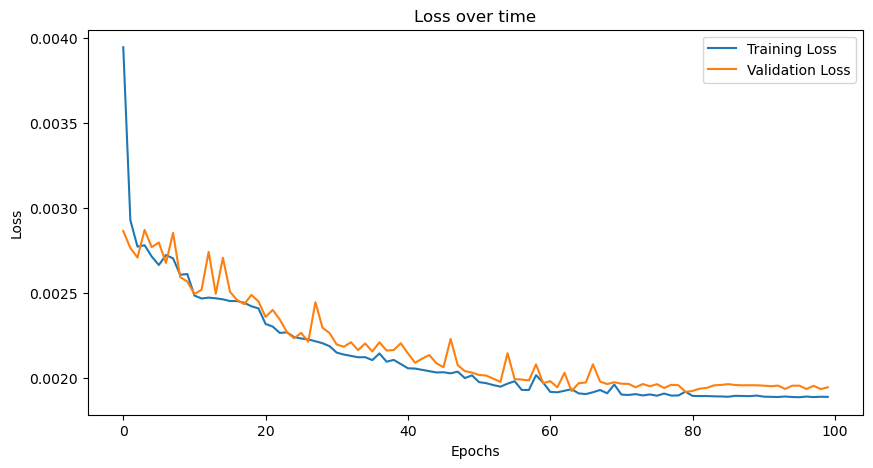

In [118]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [120]:
evaluate_model(test_loader, model_up, scaler_y)

Mean Squared Error on Test Data: 50.82566


# HS + month_sin

In [92]:
input_values, target_values = rebuild_data(df, ['HS','month_sin'], 30)

In [94]:
X_test_30, y_test_30 = rebuild_data(df_test, ['HS','month_sin'], 30)

In [95]:
X_train_30, X_val_30, y_train_30, y_val_30 = split_dataset(input_values, target_values)

In [96]:
y_train_30, scaler_y = minmax_data(np.array(y_train_30).reshape(-1,1), 'train')

In [97]:
y_val_30, _ = minmax_data(np.array(y_val_30).reshape(-1,1), 'test', scaler_y)
y_test_30, _ = minmax_data(np.array(y_test_30).reshape(-1,1), 'test', scaler_y)

In [100]:
train_loader, val_loader, test_loader = get_data_loaders(X_train_30, y_train_30, X_val_30, y_val_30, X_test_30, y_test_30, 1, batch_size=32)

In [101]:
model = LSTM(input_dim=2, hidden_dim=50, num_epochs=100)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

In [103]:
train_losses, val_losses = model.train_model(30, 2, train_loader, val_loader, optimizer, criterion, scheduler)

Epoch 1/100, Train Loss: 0.004054153356181445, Val Loss: 0.0029737716517425714
Epoch 2/100, Train Loss: 0.0027762209314529454, Val Loss: 0.002987707207297785
Epoch 3/100, Train Loss: 0.0027503496724378233, Val Loss: 0.00279836810996526
Epoch 4/100, Train Loss: 0.0026270982697036826, Val Loss: 0.0029270804956223404
Epoch 5/100, Train Loss: 0.0025877393514930785, Val Loss: 0.0025980763822598505
Epoch 6/100, Train Loss: 0.0025453286768343446, Val Loss: 0.0027623706472626134
Epoch 7/100, Train Loss: 0.0026145049532840803, Val Loss: 0.0025888492308468614
Epoch 8/100, Train Loss: 0.0024702776832118524, Val Loss: 0.0028751396443970176
Epoch 9/100, Train Loss: 0.002466703106412378, Val Loss: 0.0027200978418202132
Epoch 10/100, Train Loss: 0.0024841000318415137, Val Loss: 0.002549459547147251
Epoch 11/100, Train Loss: 0.0023247960043603646, Val Loss: 0.002531956436662048
Epoch 12/100, Train Loss: 0.0022989150687783753, Val Loss: 0.0025252155717613548
Epoch 13/100, Train Loss: 0.0023215565302252

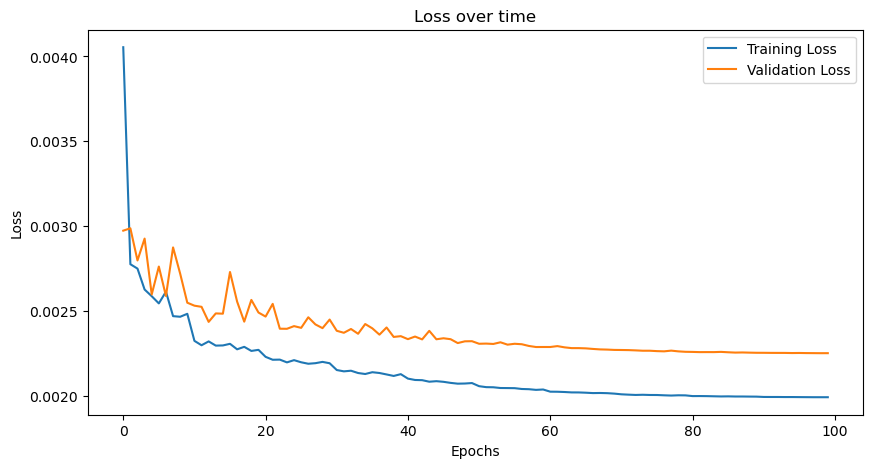

In [104]:
# Plot the loss function
plot_loss(train_losses, val_losses)

In [105]:
evaluate_model(test_loader, model, scaler_y)

Mean Squared Error on Test Data: 49.467873
